# Análise de dados e Criação de Modelos de Machine Learning para a Identificação de Pragas em Colheitas

## 1 - Importação das bibliotecas:

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import joblib
import statistics
import warnings
warnings.filterwarnings('ignore')

----------------------

## 2 - Definição dos parâmetros dos Datasets e leitura dos arquivos:

In [8]:
# Nome dos arquivos que serão lidos
amargoso = 'data/_amargoso.csv'
braquiaria = 'data/_braquiaria.csv'
caruru = 'data/_caruru.csv'
juazeiro = 'data/_juazeiro.csv'
leiteiro = 'data/_leiteiro.csv'

# Criação dos Dataframes
df_amargoso = pd.read_csv(amargoso, sep=',')
df_braquiaria = pd.read_csv(braquiaria, sep=',')
df_caruru = pd.read_csv(caruru, sep=',')
df_juazeiro = pd.read_csv(juazeiro, sep=',')
df_leiteiro = pd.read_csv(leiteiro, sep=',')

# Renomear as colunas dos Dataframes:
vec_dfs = [df_amargoso, df_braquiaria, df_caruru, df_juazeiro, df_leiteiro]

for df in vec_dfs:
    df.rename(columns={'Sample num' : 'id', 'F1 (410nm)' : 'f1', 'F2 (440nm)' : 'f2', 
                       'F3 (470nm)' : 'f3', 'F4 (510nm)' : 'f4', 'F5 (550nm)' : 'f5', 
                       'F6 (583nm)' : 'f6', 'F7 (620nm)' : 'f7', 'F8 (670nm)' : 'f8', 
                       'CLEAR' : 'clear', 'SAIDA' : 'y'}, inplace = True)
    df.drop('Function', axis=1, inplace=True)

In [9]:
# Tipos de pragas
# - 0 = Amargoso
# - 1 = Caruru
# - 2 = Juazeiro
# - 3 = Leiteiro
# - 4 = Braquiaria

df_amargoso['tipo'] = '0'
df_caruru['tipo'] = '1'
df_juazeiro['tipo'] = '2'
df_leiteiro['tipo'] = '3'
df_braquiaria['tipo'] = '4'

---------------------

## 3 - Pré-processamento dos dados

In [10]:
# Converter dados de Inteiro e Object para Float
def converter_colunas_float(df):
    df['f1'] = df.f1.astype(np.float64)
    df['f2'] = df.f2.astype(np.float64)
    df['f3'] = df.f3.astype(np.float64)
    df['f4'] = df.f4.astype(np.float64)
    df['f5'] = df.f5.astype(np.float64)
    df['f6'] = df.f6.astype(np.float64)
    df['f7'] = df.f7.astype(np.float64)
    df['f8'] = df.f8.astype(np.float64)
    df['clear'] = pd.to_numeric(df['clear'],errors='coerce')
    df['y'] = df.y.astype(np.float64)
    df['tipo'] = df.tipo.astype(np.float64)
    
    return df

In [11]:
# Dados Faltantes
# - Verificação da existência de dados faltantes
# - - Substituição de dados faltantes pelo o valor obtido com interpolação linear

def inserir_dados_faltantes(df):
    if df['f1'].isna().any():
        df['f1'] = df.f1.interpolate(method='linear')
    if df['f2'].isna().any():
        df['f2'] = df.f2.interpolate(method='linear')
    if df['f3'].isna().any():
        df['f3'] = df.f3.interpolate(method='linear')
    if df['f4'].isna().any():
        df['f4'] = df.f4.interpolate(method='linear')
    if df['f5'].isna().any():
        df['f5'] = df.f5.interpolate(method='linear')
    if df['f6'].isna().any():
        df['f6'] = df.f6.interpolate(method='linear')
    if df['f7'].isna().any():
        df['f7'] = df.f7.interpolate(method='linear')
    if df['f8'].isna().any():
        df['f8'] = df.f8.interpolate(method='linear')
    if df['clear'].isna().any():
        df['clear'] = df.clear.interpolate(method='linear')
    
    return df

In [12]:
# Vetor de Dataframes
vec_dfs = [df_amargoso,df_braquiaria,df_caruru, df_juazeiro, df_leiteiro]

vec_df_preprocessados = []

for df in vec_dfs:
    
    # Converter os dados para float
    df = converter_colunas_float(df)

    # Inserir os dados faltantes via interpolação linear
    df = inserir_dados_faltantes(df)
    
    # Inserir os Dataframes Pré-processados em um vetor
    vec_df_preprocessados.append(df)

# Concatenar todos os Dataframes
df_preprocessado = pd.concat(vec_df_preprocessados)

# Resetar o index do Dataframe
df_preprocessado = df_preprocessado.reset_index()

# Seleção dos parâmetros mais interessantes
df_preprocessado = df_preprocessado[['f1','f2','f3','f4','f5','f6','f7','f8','clear','y','tipo']]

# Salvar o DataFrame Pré-processado
df_preprocessado.to_csv('data/df_preprocessado.csv')

In [14]:
# - Informações relevantes sobre os dados pré-processados
print('-------Total de Linhas do Dataframe Pré-processado-------')
print(len(df_preprocessado))
print('-------Pré-visualização dos dados do Dataframe-------')
print(df_preprocessado.head())
print('-------Descrição dos tipos das variáveis contidas no Dataframe-------')
print(df_preprocessado.dtypes)
print('-------Descrição do Dataframe-------')
print(df_preprocessado.describe())

-------Total de Linhas do Dataframe Pré-processado-------
637
-------Pré-visualização dos dados do Dataframe-------
      f1     f2     f3     f4     f5     f6      f7      f8   clear    y  tipo
0  366.0  471.0  632.0  796.0  999.0  967.0  1326.0  1532.0  7318.0  1.0   0.0
1  336.0  459.0  595.0  811.0  987.0  953.0  1356.0  1478.0  7284.0  1.0   0.0
2  333.0  470.0  610.0  849.0  992.0  958.0  1472.0  1487.0  7427.0  1.0   0.0
3  337.0  453.0  589.0  774.0  933.0  949.0  1316.0  1406.0  6916.0  1.0   0.0
4  329.0  454.0  585.0  783.0  948.0  951.0  1311.0  1490.0  6953.0  1.0   0.0
-------Descrição dos tipos das variáveis contidas no Dataframe-------
f1       float64
f2       float64
f3       float64
f4       float64
f5       float64
f6       float64
f7       float64
f8       float64
clear    float64
y        float64
tipo     float64
dtype: object
-------Descrição do Dataframe-------
               f1          f2          f3           f4           f5  \
count  637.000000  637.000000  

-------------------

## 4 - Análise de dados

In [15]:
# Correlação entre os dados
# - Fazer a correlação de Pearson para verificar a se há correlação entre os dados.
# - - - - - - - - - - Níveis de Correlação - - - - - - - - -
# - - 0.9 para mais ou para menos indica uma correlação muito forte.
# - - 0.7 a 0.9 positivo ou negativo indica uma correlação forte.
# - - 0.5 a 0.7 positivo ou negativo indica uma correlação moderada.
# - - 0.3 a 0.5 positivo ou negativo indica uma correlação fraca.
# - - 0 a 0.3 positivo ou negativo indica uma correlação desprezível.

# Realizar a correlação entre as colunas
df_correlacao  = df_preprocessado.corr(method ='pearson')

## HeatMap

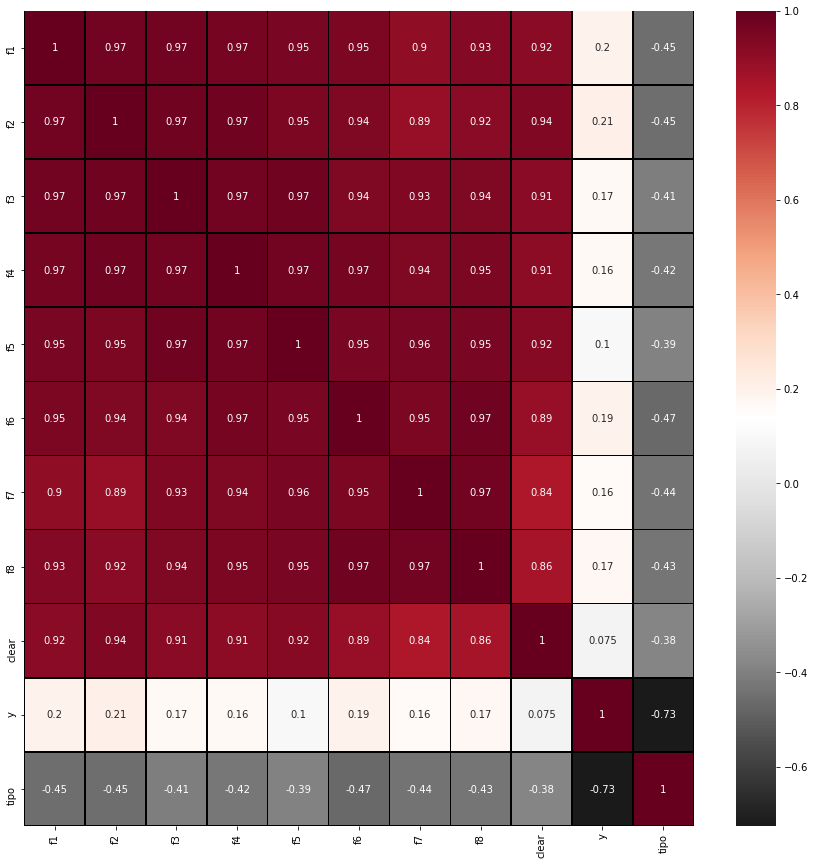

In [16]:
# Visualização das correlações entre das labels do Dataframe através de um heatmap:
%matplotlib inline
plt.figure(figsize=(15,15))
sns.heatmap(df_correlacao, annot=True, linewidths=0.5, linecolor='black', cmap='RdGy_r')
plt.xticks(rotation=90)
plt.savefig("heatmap_correlation.png", dpi=150) 
plt.show()

Conclusão: As features de "f1" até "clear" possuem uma correlação forte, logo isso é um bom indício que essas features são relacionadas, no entanto, como na base de dados possui poucos exemplos balanceados, ou seja há aproximadamente 120 casos do tipo braquiaria e mais de 500 casos de exemplos de dados com praga, logo isso impacta na correlação das features com as saídas.

-----------------------

## 5 - Criação do conjunto verdade 

### 5.1 - Solução para a identificação de pragas

In [17]:
# Resetar o index do Dataframe
df_preprocessado = df_preprocessado.reset_index()

-------------

### 5.1.1 Criação do conjunto de teste

In [18]:
# Selecionar as features necessárias
df_preprocessado_conj_vdd = df_preprocessado[['index','f1','f2','f3','f4','f5','f6','f7','f8','clear','y']]

# vetor de bases com y = 0 e y = 1
vec_conjunto_vdd = []

# Dados do Dataframe que a label "y" é 0
df_process_y0 = df_preprocessado_conj_vdd[df_preprocessado_conj_vdd['y'] == 0.0]

df_process_y0 = df_process_y0.sample(n = 13, random_state=1)

vec_conjunto_vdd.append(df_process_y0)

# Dados do Dataframe que a label "y" é 1
df_process_y1 = df_preprocessado_conj_vdd[df_preprocessado_conj_vdd['y'] == 1.0]

df_process_y1 = df_process_y1.sample(n = 13, random_state=1)

# vetor com o conjunto verdade balanceado
vec_conjunto_vdd.append(df_process_y1)

# Planejamento do conjunto de treinamento
# - 10% da base com menor frequência
# - Base com menor frequência = 128
# - Conjunto verdade = 13*2

vec_df_vdd = pd.concat(vec_conjunto_vdd)

print(vec_df_vdd)

vec_df_vdd.to_csv('data/conj_vdd_teste_identificacao_praga.csv')

     index     f1     f2     f3      f4      f5      f6      f7      f8  \
246    246  279.0  354.0  480.0   567.0   764.0   706.0   876.0   974.0   
229    229  268.0  336.0  446.0   549.0   715.0   700.0   842.0   954.0   
180    180  269.0  382.0  483.0   664.0   774.0   850.0  1083.0  1308.0   
181    181  326.0  423.0  583.0   737.0   929.0  1029.0  1248.0  1512.0   
158    158  244.0  300.0  373.0   511.0   615.0   692.0   734.0   884.0   
243    243  272.0  347.0  471.0   559.0   744.0   701.0   851.0   957.0   
247    247  279.0  357.0  476.0   568.0   751.0   707.0   877.0   986.0   
160    160  262.0  315.0  399.0   547.0   659.0   757.0   837.0   997.0   
156    156  232.0  279.0  355.0   484.0   572.0   631.0   696.0   795.0   
176    176  252.0  316.0  398.0   534.0   665.0   705.0   779.0   930.0   
233    233  263.0  333.0  438.0   541.0   707.0   704.0   813.0   947.0   
228    228  265.0  331.0  441.0   542.0   714.0   699.0   832.0   947.0   
129    129  322.0  447.0 

----------------

### 5.1.2 - Criação do conjunto para treinamento

In [19]:
# Ids do conjunto de teste
ids = vec_df_vdd['index'].values

# Conjunto de treino sem a ocorrência dos exemplos usados no teste
df_conjunto_treino = df_preprocessado[~df_preprocessado['index'].isin(ids)]

df_conjunto_treino = df_conjunto_treino[['index','f1','f2','f3','f4','f5','f6','f7','f8','clear','y']]

# vetor de bases com y = 0 e y = 1
vec_conjunto_treino = []

# Dados do Dataframe que a label "y" é 0
df_process_y0_treino = df_conjunto_treino[df_conjunto_treino['y'] == 0.0]

df_process_y0_treino = df_process_y0_treino.sample(n = 115, random_state=1)

vec_conjunto_treino.append(df_process_y0_treino)

# Dados do Dataframe que a label "y" é 1
df_process_y1_treino = df_conjunto_treino[df_conjunto_treino['y'] == 1.0]

df_process_y1_treino = df_process_y1_treino.sample(n = 115, random_state=1)

vec_conjunto_treino.append(df_process_y1_treino)

In [20]:
# Planejamento do conjunto de treinamento
# - 90% da base com menor frequência
# - Base com menor frequência = 128
# - Conjunto de treino = 115*2

vec_conjunto_treino = pd.concat(vec_conjunto_treino)

print(vec_conjunto_treino)

vec_conjunto_treino.to_csv('data/conj_vdd_treino_identificacao_praga.csv')

     index     f1     f2     f3     f4      f5      f6      f7      f8  \
226    226  265.0  329.0  438.0  544.0   703.0   706.0   824.0   954.0   
173    173  273.0  333.0  417.0  573.0   698.0   752.0   813.0  1005.0   
188    188  304.0  416.0  497.0  663.0   781.0   819.0   914.0  1145.0   
215    215  272.0  338.0  453.0  568.0   724.0   722.0   859.0   970.0   
201    201  282.0  339.0  453.0  557.0   742.0   753.0   844.0   977.0   
..     ...    ...    ...    ...    ...     ...     ...     ...     ...   
558    558  269.0  345.0  426.0  565.0   682.0   761.0   822.0  1028.0   
371    371  426.0  567.0  761.0  823.0  1009.0  1150.0  1179.0  1528.0   
429    429  314.0  439.0  550.0  706.0   842.0   873.0  1003.0  1236.0   
442    442  347.0  432.0  531.0  702.0   795.0   852.0   884.0  1093.0   
528    528  243.0  302.0  393.0  511.0   630.0   678.0   790.0   937.0   

      clear    y  
226  5122.0  0.0  
173  4505.0  0.0  
188  5634.0  0.0  
215  5265.0  0.0  
201  5710.0  0.0

----------------

### 5.2 - Solução para a identificação de qual tipo de praga

### 5.2.1 - Criação do conjunto para teste

In [21]:
# Selecionar as features necessárias
df_preprocessado_conj_vdd_praga = df_preprocessado[['index','f1','f2','f3','f4','f5','f6','f7','f8','clear','tipo']]

# vetor de bases com tipo = 0, tipo = 1, tipo = 2, tipo = 3
vec_conjunto_vdd_praga = []

# Dados do Dataframe que a label "tipo" é 0
df_process_tipo0 = df_preprocessado_conj_vdd_praga[df_preprocessado_conj_vdd_praga['tipo'] == 0.0]

df_process_tipo0 = df_process_tipo0.sample(n = 8, random_state=1)

vec_conjunto_vdd_praga.append(df_process_tipo0)

#------------------------------------------

# Dados do Dataframe que a label "tipo" é 1
df_process_tipo1 = df_preprocessado_conj_vdd_praga[df_preprocessado_conj_vdd_praga['tipo'] == 1.0]

df_process_tipo1 = df_process_tipo1.sample(n = 8, random_state=1)

vec_conjunto_vdd_praga.append(df_process_tipo1)

#------------------------------------------

# Dados do Dataframe que a label "tipo" é 2
df_process_tipo2 = df_preprocessado_conj_vdd_praga[df_preprocessado_conj_vdd_praga['tipo'] == 2.0]

df_process_tipo2 = df_process_tipo2.sample(n = 8, random_state=1)

vec_conjunto_vdd_praga.append(df_process_tipo2)

#------------------------------------------

# Dados do Dataframe que a label "tipo" é 3
df_process_tipo3 = df_preprocessado_conj_vdd_praga[df_preprocessado_conj_vdd_praga['tipo'] == 3.0]

# Selecionar uma parcela do dataset randomicamente
df_process_tipo3 = df_process_tipo3.sample(n = 8, random_state=1)

vec_conjunto_vdd_praga.append(df_process_tipo3)

# Planejamento do conjunto de teste
# - 10% da base com menor frequência
# - Base com menor frequência = 72
# - Conjunto de teste = 8*4

vec_conjunto_teste_praga = pd.concat(vec_conjunto_vdd_praga)

print(vec_conjunto_teste_praga)

vec_conjunto_teste_praga.to_csv('data/conj_vdd_teste_identificacao_tipo_praga.csv')


     index     f1     f2     f3      f4      f5      f6      f7      f8  \
74      74  378.0  480.0  591.0   736.0   931.0  1014.0  1076.0  1303.0   
45      45  349.0  452.0  561.0   718.0   862.0   933.0  1014.0  1339.0   
48      48  334.0  535.0  545.0   870.0   843.0  1138.0  1374.0  1363.0   
31      31  289.0  348.0  446.0   596.0   724.0   862.0  1016.0  1186.0   
65      65  392.0  504.0  652.0   765.0   984.0  1103.0  1105.0  1377.0   
66      66  365.0  482.0  573.0   732.0   870.0  1018.0   976.0  1284.0   
118    118  350.0  468.0  577.0   709.0   841.0   981.0  1021.0  1262.0   
100    100  299.0  425.0  493.0   709.0   788.0   954.0   942.0  1209.0   
272    272  452.0  597.0  820.0   936.0  1180.0  1257.0  1628.0  2043.0   
308    308  430.0  535.0  691.0   952.0  1095.0  1248.0  1579.0  1795.0   
263    263  438.0  580.0  775.0   956.0  1221.0  1266.0  1636.0  2038.0   
321    321  437.0  528.0  691.0   885.0  1044.0  1197.0  1491.0  1786.0   
306    306  407.0  521.0 

--------------------

### 5.2.2 - Criação do conjunto para treinamento

In [22]:
# Ids do conjunto de teste
ids_praga = vec_conjunto_teste_praga['index'].values

# Conjunto de treino sem a ocorrência dos exemplos usados no teste
df_conjunto_treino_praga = df_preprocessado[~df_preprocessado['index'].isin(ids_praga)]

df_conjunto_treino_praga = df_conjunto_treino_praga[['index','f1','f2','f3','f4','f5','f6','f7','f8','clear','tipo']]

# vetor de bases com tipo = 0, tipo = 1, tipo = 2, tipo = 3
vec_conjunto_treino_praga = []

# Dados do Dataframe que a label "tipo" é 0
df_process_tipo0_treino = df_conjunto_treino_praga[df_conjunto_treino_praga['tipo'] == 0.0]

# Selecionar uma parcela do dataset randomicamente
df_process_tipo0_treino = df_process_tipo0_treino.sample(n = 64, random_state=1)

vec_conjunto_treino_praga.append(df_process_tipo0_treino)

#--------------------------

# Dados do Dataframe que a label "tipo" é 1
df_process_tipo1_treino = df_conjunto_treino_praga[df_conjunto_treino_praga['tipo'] == 1.0]

# Selecionar uma parcela do dataset randomicamente
df_process_tipo1_treino = df_process_tipo1_treino.sample(n = 64, random_state=1)

vec_conjunto_treino_praga.append(df_process_tipo1_treino)

#--------------------------

# Dados do Dataframe que a label "tipo" é 2
df_process_tipo2_treino = df_conjunto_treino_praga[df_conjunto_treino_praga['tipo'] == 2.0]

# Selecionar uma parcela do dataset randomicamente
df_process_tipo2_treino = df_process_tipo2_treino.sample(n = 64, random_state=1)

vec_conjunto_treino_praga.append(df_process_tipo2_treino)

#--------------------------

# Dados do Dataframe que a label "tipo" é 3
df_process_tipo3_treino = df_conjunto_treino_praga[df_conjunto_treino_praga['tipo'] == 3.0]

# Selecionar uma parcela do dataset randomicamente
df_process_tipo3_treino = df_process_tipo3_treino.sample(n = 64, random_state=1)

vec_conjunto_treino_praga.append(df_process_tipo3_treino)

# Planejamento do conjunto de teste
# - 90% da base com menor frequência
# - Base com menor frequência = 72
# - Conjunto de teste = 64*4

vec_conjunto_treino_praga_ok = pd.concat(vec_conjunto_treino_praga)

print(vec_conjunto_treino_praga_ok)

vec_conjunto_treino_praga_ok.to_csv('data/conj_vdd_treino_identificacao_tipo_praga.csv')

     index     f1     f2     f3     f4      f5      f6      f7      f8  \
75      75  354.0  473.0  541.0  716.0   878.0   991.0   990.0  1259.0   
49      49  305.0  402.0  475.0  618.0   787.0   863.0   995.0  1118.0   
61      61  363.0  490.0  586.0  791.0   969.0  1270.0  1261.0  1804.0   
122    122  387.0  524.0  658.0  825.0   919.0   877.0  1112.0  1389.0   
79      79  385.0  528.0  621.0  832.0  1063.0  1040.0  1304.0  1514.0   
..     ...    ...    ...    ...    ...     ...     ...     ...     ...   
612    612  248.0  311.0  385.0  510.0   624.0   685.0   741.0   887.0   
570    570  238.0  294.0  362.0  463.0   551.0   622.0   654.0   795.0   
551    551  252.0  342.0  434.0  550.0   667.0   703.0   835.0   994.0   
622    622  227.0  278.0  348.0  436.0   538.0   589.0   648.0   770.0   
561    561  268.0  347.0  434.0  568.0   710.0   761.0   825.0  1051.0   

      clear  tipo  
75   8699.0   0.0  
49   6170.0   0.0  
61   8317.0   0.0  
122  7230.0   0.0  
79   9863.0

-------------------

## 6 - Modelos de Classificação

## 6.1 - Funções para auxiliar a otimização de hiperparâmetros

#### Cross Validation

In [23]:
def validacao_cruzada(model,X,target):
        
    modelo = model

    kf = KFold(10, shuffle=True, random_state=1)

    ac_v = []
    cm_v = []
    p_v = []
    r_v = []
    f1_v = []
    e_v = []
    predicts = []
    targets = []

    for train_index,teste_index in kf.split(X,target):

        X_train, X_test = X[train_index],X[teste_index]

        y_train, y_test = target[train_index], target[teste_index]

        model.fit(X_train,y_train)
        pred = model.predict(X_test)
        ac = accuracy_score(y_test, pred)
        p = precision_score(y_test, pred,average='weighted')
        r = recall_score(y_test, pred,average='weighted')
        f1 = (2*p*r)/(p+r)
        e = mean_squared_error(y_test, pred)
        cm = confusion_matrix(y_test,pred)
        cm_v.append(cm)
        ac_v.append(ac)
        p_v.append(p)
        r_v.append(r)
        f1_v.append(f1)
        e_v.append(e)
        predicts.append(pred)
        targets.append(y_test)

    ac = statistics.median(ac_v)
    p = statistics.median(p_v)
    f1 = statistics.median(f1_v)
    r = statistics.median(r_v)
    e = statistics.median(e_v)

    print('--------------------')
    print('acuracia:', ac)
    print('precisao:', p)
    print('recall:', r)
    print('f1-score:', f1)
    print('erro:', e)
    print('--------------------')
    
    return predicts,targets,ac,p,r,f1,e,ac_v

#### Random Forest

In [24]:
def melhores_parametros_RF(X,y):
    
    param_grid = {
        'bootstrap': [True],
        'max_depth': [80, 90, 100, 110],
        'max_features': [2, 3, 5],
        'min_samples_leaf': [3, 4, 5, 8],
        'min_samples_split': [5, 8, 10, 12],
        'n_estimators': [100, 200, 300, 500, 1000]
    }

    rf = RandomForestRegressor()
    
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, n_jobs = -1, verbose = 2)
    grid_search.fit(X, y.values.ravel())

    print(grid_search.best_params_)

In [25]:
def comparacao_RF(X, y, n_estimators, min_samples_split, min_samples_leaf, max_features, max_depth, bootstrap):
        
    print('-----RF SEM OTIMIZAÇÃO------')

    base_model = RandomForestClassifier()

    base_rf = validacao_cruzada(base_model, X, y.values.ravel())

    print('-----RF COM OTIMIZAÇÃO-----')

    best_random = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, max_features = max_features, max_depth = max_depth, bootstrap=bootstrap)

    best_rf = validacao_cruzada(best_random, X, y.values.ravel())

    return 1
    

#### SVM

In [26]:
def melhores_parametros_SVM(X,y):
    Cs = [0.001, 0.01, 0.1, 1, 10, 100]
    gammas = [0.001, 0.01, 0.1, 1, 10, 100, 'auto']
    kernel = ['linear', 'rbf']
    decision_function_shape = ['ovo','ovr']
    shrinking = [True,False]
    
    param_grid = {'C': Cs, 
                  'gamma' : gammas, 
                  'kernel': kernel, 
                  'decision_function_shape': decision_function_shape, 
                  'shrinking': shrinking}
    
    grid_search = GridSearchCV(SVC(), param_grid, cv=10, n_jobs = -1, verbose = 2)
    grid_search.fit(X, y.values.ravel())
        
    print(grid_search.best_params_)

In [27]:
def comparacao_SVM(X, y, C, gamma, kernel, decision_function_shape, shrinking):
    
    print('-----SVM SEM OTIMIZAÇÂO-----')
    clf = SVC()

    base_svc = validacao_cruzada(clf, X, y.values.ravel())
    
    print('-----SVM COM OTIMIZAÇÂO-----')
    
    clf = SVC(C=C, gamma=gamma, kernel= kernel, decision_function_shape = decision_function_shape, shrinking = shrinking)

    best_svc = validacao_cruzada(clf, X, y.values.ravel())
    
    return 1

#### NB

In [28]:
def melhores_parametros_NB(X,y):
    
    gaussian_nb = GaussianNB() 
    
    params_NB = {
        'var_smoothing': np.logspace(0,-100, num=100)
    }
    
    grid_search = GridSearchCV(gaussian_nb, params_NB, cv=10, n_jobs = -1, verbose = 2)
    grid_search.fit(X, y.values.ravel())

    print(grid_search.best_params_)

In [29]:
def comparacao_NB(X,y,var_smoothing):
        
    print('-----NB SEM OTIMIZAÇÂO-----')

    clf = GaussianNB()

    base_nb = validacao_cruzada(clf, X, y.values.ravel())
    
    print('-----NB COM OTIMIZAÇÂO-----')
    
    eclf = GaussianNB(var_smoothing = var_smoothing)

    best_nb = validacao_cruzada(eclf, X, y.values.ravel())
    
    return 1

#### DT

In [30]:
def melhores_parametros_DT(X,y):

    dt_classifier = DecisionTreeClassifier() 

    max_depth = range(1,1000)
    criterion = ['gini', 'entropy']
    param_grid = {'max_depth': max_depth, 
                  'criterion' : criterion}
    
    grid_search = GridSearchCV(dt_classifier, param_grid, cv=10, n_jobs = -1, verbose = 2)
    grid_search.fit(X, y.values.ravel())

    print(grid_search.best_params_)

In [31]:
def comparacao_DT(X,y,criterion,max_depth):
    
    print('-----DT SEM OTIMIZAÇÂO-----')

    clf = DecisionTreeClassifier()

    base_dt = validacao_cruzada(clf, X, y.values.ravel())
    
    print('-----DT COM OTIMIZAÇÂO-----')
    
    eclf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth)

    best_dt = validacao_cruzada(eclf, X, y.values.ravel())
    
    return 1

#### RL

In [32]:
def melhores_parametros_RL(X,y):
    
    lr_classifier = LogisticRegression() 
     
    param_grid = {'penalty': ['l1', 'l2'],
                  'C':[0.001,0.009,0.01,0.09,1,5,10,25,50,100], 
                  'solver' : ['liblinear','saga'], 
                  'multi_class' : ['ovr','auto']}
   
    grid_search = GridSearchCV(lr_classifier, param_grid, cv=10, n_jobs = -1, verbose = 2)
    grid_search.fit(X, y.values.ravel())

    print(grid_search.best_params_)

In [33]:
def comparacao_RL(X,y,C,penalty,multi_class,solver):
    
    print('-----RL SEM OTIMIZAÇÂO-----')
    clf = LogisticRegression()

    base_rl = validacao_cruzada(clf, X, y.values.ravel())
    
    print('-----RL COM OTIMIZAÇÂO-----')
    eclf = LogisticRegression(C = C, penalty = penalty, multi_class=multi_class, solver=solver)

    best_rl = validacao_cruzada(eclf, X, y.values.ravel())
        

----------------

## 6.2 - Identificação de pragas

In [34]:
# Carregar os dados
dados = pd.read_csv('data/conj_vdd_treino_identificacao_praga.csv')

# Embaralhar os dados
dados = dados.sample(n = 230) 

# Excluir e resetar as colunas que não são importantes
dados = dados.drop('Unnamed: 0', 1)
dados = dados.drop('index', 1)

print(dados)

#------Features------
X_id_praga = dados.iloc[:, 0: len(dados.columns)-1]
y_id_praga = dados.iloc[:, len(dados.columns)-1:len(dados.columns)]

#------Normalização das Features------
scaler = Normalizer()
X_id_praga = scaler.fit_transform(X_id_praga)

        f1     f2     f3     f4      f5      f6      f7      f8   clear    y
78   260.0  378.0  496.0  636.0   782.0   757.0   994.0  1207.0  5787.0  0.0
159  435.0  521.0  658.0  816.0  1014.0  1135.0  1154.0  1450.0  8361.0  1.0
53   295.0  375.0  503.0  620.0   747.0   794.0   929.0  1157.0  5534.0  0.0
97   302.0  420.0  495.0  729.0   791.0   938.0   958.0  1318.0  5683.0  0.0
221  412.0  553.0  666.0  836.0   973.0  1075.0  1177.0  1464.0  8054.0  1.0
..     ...    ...    ...    ...     ...     ...     ...     ...     ...  ...
38   337.0  399.0  552.0  673.0   820.0   749.0   992.0  1123.0  5960.0  0.0
35   265.0  337.0  453.0  540.0   718.0   694.0   815.0   946.0  5496.0  0.0
47   324.0  464.0  548.0  785.0   870.0   939.0  1097.0  1224.0  7272.0  0.0
99   382.0  497.0  666.0  864.0  1116.0  1221.0  1412.0  1706.0  8676.0  0.0
190  262.0  335.0  413.0  552.0   664.0   712.0   780.0   953.0  4525.0  1.0

[230 rows x 10 columns]


--------------

### 6.2.1 - Otimização de Hiperparâmetros do Random Forest

In [35]:
# Busca pelos melhores parâmetros para se usar no Random Forest
#melhores_parametros_RF(X_id_praga,y_id_praga)

Melhores parâmetros para RF:
- n_estimators: 500
- min_samples_split: 5
- min_samples_leaf: 3
- max_features: 5
- max_depth: 90
- bootstrap: True

Tempo de Execução: 57.3min finished

In [36]:
# Comparação entre os melhores parâmetros encontrados do RF com o default
comparacao_RF(X_id_praga,
              y_id_praga,
              n_estimators = 500, 
              min_samples_split = 5, 
              min_samples_leaf = 3, 
              max_features = 5, 
              max_depth = 90, 
              bootstrap=True) 

-----RF SEM OTIMIZAÇÃO------
--------------------
acuracia: 0.8260869565217391
precisao: 0.859666149068323
recall: 0.8260869565217391
f1-score: 0.8421699895801886
erro: 0.17391304347826086
--------------------
-----RF COM OTIMIZAÇÃO-----
--------------------
acuracia: 0.8478260869565217
precisao: 0.859666149068323
recall: 0.8478260869565217
f1-score: 0.853248066846478
erro: 0.15217391304347827
--------------------


1

### 6.2.2 - Otimização de Hiperparâmetros do SVM

In [37]:
# Busca pelos melhores parâmetros para se usar no SVM
#melhores_parametros_SVM(X_id_praga, y_id_praga)

Melhores parâmetros para o SVM:
- C: 100
- Gamma: 100
- Kernel: rbf
- decision_function_shape: ovo
- shrinking: True

Tempo de Execução: 100

In [38]:
comparacao_SVM(X_id_praga, 
               y_id_praga, 
               100, 
               100, 
               'rbf', 
               'ovo', 
               True)

-----SVM SEM OTIMIZAÇÂO-----
--------------------
acuracia: 0.41304347826086957
precisao: 0.17107750472589792
recall: 0.41304347826086957
f1-score: 0.2418066534914361
erro: 0.5869565217391304
--------------------
-----SVM COM OTIMIZAÇÂO-----
--------------------
acuracia: 0.9130434782608695
precisao: 0.9276375798114929
recall: 0.9130434782608695
f1-score: 0.9202822779012365
erro: 0.08695652173913043
--------------------


1

### 6.2.3 - Otimização de Hiperparâmetros da Regressão Logística

In [39]:
# Busca pelos melhores parâmetros para se usar no RL
#melhores_parametros_RL(X_id_praga,y_id_praga)

Melhores parâmetros para a RL:
- C: 100
- penalty: l1
- multi_class: ovr
- solver: liblinear

Tempo de execução: 4.9s finished

In [40]:
comparacao_RL(X_id_praga, 
              y_id_praga,
              100,
              'l1', 
              'ovr', 
              'liblinear')

-----RL SEM OTIMIZAÇÂO-----
--------------------
acuracia: 0.5217391304347826
precisao: 0.5912190963341859
recall: 0.5217391304347826
f1-score: 0.5579778819604896
erro: 0.4782608695652174
--------------------
-----RL COM OTIMIZAÇÂO-----
--------------------
acuracia: 0.9130434782608695
precisao: 0.9130434782608695
recall: 0.9130434782608695
f1-score: 0.9130434782608695
erro: 0.08695652173913043
--------------------


### 6.2.4 - Otimização de Hiperparâmetros do Naive Bayes

In [41]:
# Busca pelos melhores parâmetros para se usar no NB
#melhores_parametros_NB(X_id_praga,y_id_praga)

Melhores parâmetros para o NB:
- var_smoothing: 0.0009326033468832199

Tempo de execução: 1.6s finished

In [42]:
comparacao_NB(X_id_praga, 
              y_id_praga,
              0.0009326033468832199)

-----NB SEM OTIMIZAÇÂO-----
--------------------
acuracia: 0.6521739130434783
precisao: 0.6539855072463767
recall: 0.6521739130434783
f1-score: 0.6512655928303257
erro: 0.34782608695652173
--------------------
-----NB COM OTIMIZAÇÂO-----
--------------------
acuracia: 0.6521739130434783
precisao: 0.6539855072463767
recall: 0.6521739130434783
f1-score: 0.6512655928303257
erro: 0.34782608695652173
--------------------


1

### 6.2.5 - Otimização de Hiperparâmetros do Decision Tree

In [43]:
# Busca pelos melhores parâmetros para se usar no DT
#melhores_parametros_DT(X_id_praga,y_id_praga)

Melhores parâmetros para o DT:
- criterion: entropy
- max_depth: 617

Tempo de Execução: 33.9s finished

In [44]:
comparacao_DT(X_id_praga,
              y_id_praga,
              'entropy',
              617)

-----DT SEM OTIMIZAÇÂO-----
--------------------
acuracia: 0.782608695652174
precisao: 0.8148880105401844
recall: 0.782608695652174
f1-score: 0.8034515797852355
erro: 0.21739130434782608
--------------------
-----DT COM OTIMIZAÇÂO-----
--------------------
acuracia: 0.8043478260869565
precisao: 0.8391210239036326
recall: 0.8043478260869565
f1-score: 0.8251871621852842
erro: 0.19565217391304346
--------------------


1

------------

## 6.2.6 - Avaliação na base de teste e validação estatística quanto aos outros classificadores

In [45]:
# Carregar os dados
dados_praga_teste = pd.read_csv('data/conj_vdd_teste_identificacao_praga.csv')

# Embaralhar os dados
dados_praga_teste = dados_praga_teste.sample(n = 26) 

# Excluir e resetar as colunas que não são importantes
dados_praga_teste = dados_praga_teste.drop('Unnamed: 0', 1)
dados_praga_teste = dados_praga_teste.drop('index', 1)

print(dados_praga_teste)

#------Features------
X_id_praga_teste = dados_praga_teste.iloc[:, 0: len(dados_praga_teste.columns)-1]
y_id_praga_teste = dados_praga_teste.iloc[:, len(dados_praga_teste.columns)-1:len(dados_praga_teste.columns)]

#------Normalização das Features------
scaler = Normalizer()
X_id_praga_teste = scaler.fit_transform(X_id_praga_teste)

       f1     f2     f3      f4      f5      f6      f7      f8   clear    y
14  240.0  311.0  405.0   528.0   630.0   702.0   842.0   990.0  3854.0  1.0
4   244.0  300.0  373.0   511.0   615.0   692.0   734.0   884.0  4418.0  0.0
19  307.0  438.0  546.0   712.0   852.0   822.0  1032.0  1091.0  6841.0  1.0
7   262.0  315.0  399.0   547.0   659.0   757.0   837.0   997.0  4237.0  0.0
9   252.0  316.0  398.0   534.0   665.0   705.0   779.0   930.0  4376.0  0.0
17  239.0  290.0  389.0   490.0   610.0   685.0   779.0   918.0  4067.0  1.0
23  248.0  311.0  385.0   510.0   624.0   685.0   741.0   887.0  3988.0  1.0
15  337.0  443.0  524.0   663.0   784.0   949.0   946.0  1292.0  6253.0  1.0
21  301.0  402.0  481.0   632.0   735.0   847.0   874.0  1096.0  6570.0  1.0
6   279.0  357.0  476.0   568.0   751.0   707.0   877.0   986.0  5710.0  0.0
5   272.0  347.0  471.0   559.0   744.0   701.0   851.0   957.0  5630.0  0.0
0   279.0  354.0  480.0   567.0   764.0   706.0   876.0   974.0  5791.0  0.0

In [46]:
#  Criação do Dataframe com resultados dos classificadores
colunas = ['tipo', 'acurácia','precisão', 'recall', 'f1score']
df_resultado_praga = pd.DataFrame(columns = colunas)

# Criação do Dataframe com os valores de saída preditos
colunas = ['y_rf', 'y_dt', 'y_svm', 'y_rl', 'y_nb']
df_valores_preditos_praga = pd.DataFrame(columns = colunas)

### RF

In [47]:
# Criação do modelo
modelo_rf_praga = RandomForestClassifier(n_estimators = 500, min_samples_split = 5, 
                                         min_samples_leaf = 3, max_features = 5, 
                                         max_depth = 90, bootstrap=True)

# Treinamento do modelo
modelo_rf_praga = modelo_rf_praga.fit(X_id_praga, y_id_praga.values)

# Prevendo os valores de y
result_rf_praga = modelo_rf_praga.predict(X_id_praga_teste)

# Métricas de avaliação
metricas = precision_recall_fscore_support(y_id_praga_teste.values, result_rf_praga, average='macro')

# Acurácia do Modelo
acuracia = modelo_rf_praga.score(X_id_praga_teste, y_id_praga_teste.values)

# Inclusão das métricas de avaliação
df_resultado_praga.loc[0, 'tipo'] = 'RF'
df_resultado_praga.loc[0, 'acurácia'] = acuracia
df_resultado_praga.loc[0, 'precisão'] = metricas[0]
df_resultado_praga.loc[0, 'recall'] = metricas[1]
df_resultado_praga.loc[0,'f1score'] = metricas[2]

# Incluir os valores preditos pelo RF
df_valores_preditos_praga['y_rf'] = result_rf_praga

### DT

In [48]:
# Criação do modelo
modelo_dt_praga = DecisionTreeClassifier(criterion = 'entropy', max_depth = 617)

# Treinamento do modelo
modelo_dt_praga = modelo_dt_praga.fit(X_id_praga, y_id_praga.values)

# Prevendo os valores de y
result_dt_praga = modelo_dt_praga.predict(X_id_praga_teste)

# Métricas de avaliação
metricas = precision_recall_fscore_support(y_id_praga_teste.values, result_dt_praga, average='macro')

# Acurácia do Modelo
acuracia = modelo_dt_praga.score(X_id_praga_teste, y_id_praga_teste.values)

# Inclusão das métricas de avaliação
df_resultado_praga.loc[1, 'tipo'] = 'DT'
df_resultado_praga.loc[1, 'acurácia'] = acuracia
df_resultado_praga.loc[1, 'precisão'] = metricas[0]
df_resultado_praga.loc[1, 'recall'] = metricas[1]
df_resultado_praga.loc[1,'f1score'] = metricas[2]

# Incluir os valores preditos pelo DT
df_valores_preditos_praga['y_dt'] = result_dt_praga

### SVM

In [49]:
# Criação do modelo
modelo_svm_praga = SVC(C= 100, gamma= 100, kernel= 'rbf', decision_function_shape = 'ovo', shrinking = True)
         
# Treinamento do modelo
modelo_svm_praga = modelo_svm_praga.fit(X_id_praga, y_id_praga.values)

# Prevendo os valores de y
result_svm_praga = modelo_svm_praga.predict(X_id_praga_teste)

# Métricas de avaliação
metricas = precision_recall_fscore_support(y_id_praga_teste.values, result_svm_praga, average='macro')

# Acurácia do Modelo
acuracia = modelo_svm_praga.score(X_id_praga_teste, y_id_praga_teste.values)

# Inclusão das métricas de avaliação
df_resultado_praga.loc[2, 'tipo'] = 'SVM'
df_resultado_praga.loc[2, 'acurácia'] = acuracia
df_resultado_praga.loc[2, 'precisão'] = metricas[0]
df_resultado_praga.loc[2, 'recall'] = metricas[1]
df_resultado_praga.loc[2,'f1score'] = metricas[2]

# Incluir os valores preditos pelo SVM
df_valores_preditos_praga['y_svm'] = result_svm_praga

### RL

In [50]:
# Criação do modelo
modelo_rl_praga = LogisticRegression(C = 100, penalty = 'l1', multi_class= 'ovr', solver= 'liblinear')

# Treinamento do modelo
modelo_rl_praga = modelo_rl_praga.fit(X_id_praga, y_id_praga.values)

# Prevendo os valores de y
result_rl_praga = modelo_rl_praga.predict(X_id_praga_teste)

# Métricas de avaliação
metricas = precision_recall_fscore_support(y_id_praga_teste.values, result_rl_praga, average='macro')

# Acurácia do Modelo
acuracia = modelo_rl_praga.score(X_id_praga_teste, y_id_praga_teste.values)

# Inclusão das métricas de avaliação
df_resultado_praga.loc[3, 'tipo'] = 'RL'
df_resultado_praga.loc[3, 'acurácia'] = acuracia
df_resultado_praga.loc[3, 'precisão'] = metricas[0]
df_resultado_praga.loc[3, 'recall'] = metricas[1]
df_resultado_praga.loc[3,'f1score'] = metricas[2]

# Incluir os valores preditos pelo RL
df_valores_preditos_praga['y_rl'] = result_rl_praga

### NB

In [51]:
# Criação do modelo
modelo_nb_praga = GaussianNB(var_smoothing = 0.0009326033468832199)

# Treinamento do modelo
modelo_nb_praga = modelo_nb_praga.fit(X_id_praga, y_id_praga.values)

# Prevendo os valores de y
result_nb_praga = modelo_nb_praga.predict(X_id_praga_teste)

# Métricas de avaliação
metricas = precision_recall_fscore_support(y_id_praga_teste.values, result_nb_praga, average='macro')

# Acurácia do Modelo
acuracia = modelo_nb_praga.score(X_id_praga_teste, y_id_praga_teste.values)

# Inclusão das métricas de avaliação
df_resultado_praga.loc[4, 'tipo'] = 'NB'
df_resultado_praga.loc[4, 'acurácia'] = acuracia
df_resultado_praga.loc[4, 'precisão'] = metricas[0]
df_resultado_praga.loc[4, 'recall'] = metricas[1]
df_resultado_praga.loc[4,'f1score'] = metricas[2]


# Incluir os valores preditos pelo NB
df_valores_preditos_praga['y_nb'] = result_nb_praga

### Dataframe com os resultados dos classificadores

In [52]:
# Salvar em um arquivo CSV
df_resultado_praga.to_csv('data/df_resultado_praga.csv')

df_resultado_praga.head()

,tipo,acurácia,precisão,recall,f1score
0,RF,0.884615,0.886905,0.884615,0.884444
1,DT,0.807692,0.809524,0.807692,0.807407
2,SVM,0.884615,0.886905,0.884615,0.884444
3,RL,0.846154,0.846154,0.846154,0.846154
4,NB,0.653846,0.662500,0.653846,0.649175


### Dataframe com os valores preditos

In [53]:
print(df_valores_preditos_praga)

# Salvar em um arquivo CSV
df_valores_preditos_praga.to_csv('data/df_valores_preditos_praga.csv')

    y_rf  y_dt  y_svm  y_rl  y_nb
0    1.0   1.0    1.0   1.0   1.0
1    0.0   0.0    0.0   0.0   0.0
2    0.0   0.0    0.0   0.0   0.0
3    0.0   0.0    0.0   0.0   1.0
4    1.0   1.0    0.0   0.0   1.0
5    1.0   1.0    1.0   1.0   1.0
6    1.0   1.0    1.0   1.0   1.0
7    1.0   0.0    1.0   1.0   0.0
8    1.0   1.0    1.0   1.0   0.0
9    0.0   0.0    0.0   0.0   0.0
10   0.0   0.0    0.0   0.0   0.0
11   0.0   0.0    0.0   0.0   0.0
12   1.0   0.0    1.0   1.0   1.0
13   0.0   0.0    0.0   0.0   0.0
14   0.0   0.0    0.0   0.0   1.0
15   0.0   0.0    0.0   0.0   0.0
16   0.0   0.0    0.0   0.0   0.0
17   1.0   1.0    1.0   1.0   0.0
18   0.0   0.0    1.0   1.0   0.0
19   1.0   1.0    1.0   1.0   0.0
20   1.0   1.0    1.0   1.0   1.0
21   1.0   1.0    1.0   0.0   0.0
22   1.0   1.0    1.0   1.0   0.0
23   0.0   0.0    0.0   0.0   0.0
24   1.0   1.0    1.0   1.0   1.0
25   1.0   1.0    1.0   1.0   1.0


--------------------

## Validação Estatística

Objetivo: Identificar quais modelos que ao serem otimizados os hiperparâmetros podem alcançar o resultado de outros modelos. Inclusive, esta etapa é importante pois algoritmos baseados em árvores (Random Forest e Decision Tree) e repartição de hiperplanos (SVM) tendem a ter um custo computacional maior. Desse modo, em problemas computacionais complexos (processamento de imagens), caso uma abordagem com custo coputacional menor não tiver diferença estatística, logo recomenda-se otimizar os hiperparâmetros dela até encontrar a solução ideal, ou seja com maior precisão.

### Análise de Distribuição

#### -> Teste utilizado: Shapiro Wilk

#### -> H0(Hipótese nula): A amostra segue a distribuição normal, se o p-valor >= 0.05
    
#### -> H1: A amostra não segue a distribuição normal, se o p-valor < 0.05.


In [54]:
# Carregar os resultados da análise de distribuição feita no R
analise_distribuicao_praga = pd.read_csv('data/shapiro-wilk-test-praga.csv')

analise_distribuicao_praga.head()

,Unnamed: 0,svm,rl,rf,dt,nv
0,1,8.095442e-07,8.601624e-07,4.986669e-07,6.749543e-07,0.661188


Como a maioria das correlações de Pearson foram inderiores a 0.05, logo a amostra é não paramétrica!

### Análise de Variável Independente

#### -> H0(Hipótese nula): Todos os algoritmos são equivalentes, se o p-valor >= 0.05;
#### -> H1: Os algoritmos têm diferença, se o p-valor < 0.05.

In [55]:
# Carregar os resultados da análise de variável independente feita no R
var_independente_praga = pd.read_csv('data/t-test-praga.csv')

var_independente_praga.head()

,Unnamed: 0,svm,dt,rf,rl
0,dt,1,NaN,NaN,NaN
1,rf,1,1.0,NaN,NaN
2,rl,1,1.0,1.0,NaN
3,nv,1,1.0,1.0,1.0


Não há diferença estatística entre os modelos

------------------------------------------------------

## 6.2.7 - Criação do Modelo de identificação de pragas

### O RF foi escolhido, pois nos experimentos de validação quanto a base de testes demontrou-se o mais promissor

### Matriz de Confusão do RF

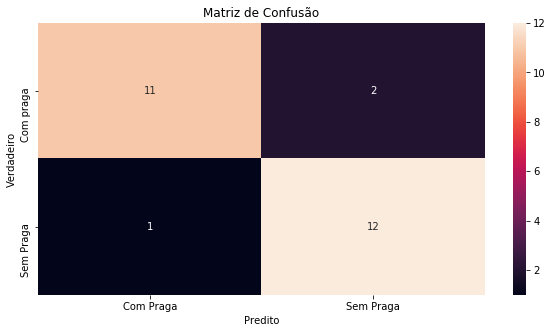

In [56]:
# Matriz de Confusao
matriz_confusao = confusion_matrix(y_id_praga_teste.values, result_rf_praga)

# Mapa com Seaborn
plt.figure(figsize=(10,5))
ax= plt.subplot()
sns.heatmap(matriz_confusao, annot=True, ax = ax);

ax.set_xlabel('Predito');
ax.set_ylabel('Verdadeiro'); 
ax.set_title('Matriz de Confusão'); 
ax.xaxis.set_ticklabels(['Com Praga', 'Sem Praga']); 
ax.yaxis.set_ticklabels(['Com praga', 'Sem Praga']);
plt.savefig("matriz_confusao_praga.png", dpi=150) 


### Salvar o modelo via Pickle

In [57]:
# Nome do arquivo que será salvo o modelo
nome_arquivo_praga = 'modelos/rf_train_modelo_identificacao_praga.sav'

# Dump do modelo
pickle.dump(modelo_svm_praga, open(nome_arquivo_praga, 'wb'))

---------------------

## 6.3 - Identificação de tipos de pragas

In [58]:
# Carregar os dados
dados_tipo_praga = pd.read_csv('data/conj_vdd_treino_identificacao_tipo_praga.csv')

# Embaralhar os dados
dados_tipo_praga = dados_tipo_praga.sample(n = 256) 

# Excluir e resetar as colunas que não são importantes
dados_tipo_praga = dados_tipo_praga.drop('Unnamed: 0', 1)
dados_tipo_praga = dados_tipo_praga.drop('index', 1)

print(dados_tipo_praga)

#------Features------
X_id_tipo_praga = dados_tipo_praga.iloc[:, 0: len(dados_tipo_praga.columns)-1]
y_id_tipo_praga = dados_tipo_praga.iloc[:, len(dados_tipo_praga.columns)-1:len(dados_tipo_praga.columns)]

#------Normalização das Features------
scaler = Normalizer()
X_id_tipo_praga = scaler.fit_transform(X_id_tipo_praga)

        f1     f2     f3     f4      f5      f6      f7      f8   clear  tipo
160  393.0  531.0  663.0  798.0   964.0  1089.0  1148.0  1485.0  7933.0   2.0
5    347.0  532.0  579.0  811.0   932.0  1215.0  1290.0  1696.0  7310.0   0.0
213  257.0  330.0  410.0  536.0   647.0   708.0   764.0   933.0  4112.0   3.0
36   290.0  350.0  447.0  600.0   726.0   865.0  1021.0  1193.0  4775.0   0.0
147  336.0  480.0  563.0  720.0   832.0   941.0  1062.0  1426.0  7013.0   2.0
..     ...    ...    ...    ...     ...     ...     ...     ...     ...   ...
72   397.0  500.0  650.0  912.0  1051.0  1237.0  1560.0  1733.0  7431.0   1.0
255  268.0  347.0  434.0  568.0   710.0   761.0   825.0  1051.0  4776.0   3.0
30   287.0  350.0  445.0  598.0   722.0   862.0  1020.0  1195.0  4764.0   0.0
17   336.0  471.0  565.0  748.0   851.0  1018.0  1141.0  1525.0  7386.0   0.0
16   364.0  516.0  598.0  808.0   903.0  1241.0  1158.0  1643.0  7577.0   0.0

[256 rows x 10 columns]


-------------

### 6.3.1 - Otimização de Hiperparâmetros do Random Forest

In [59]:
# Busca pelos melhores parâmetros para se usar no RF
#melhores_parametros_RF(X_id_tipo_praga,y_id_tipo_praga)

Melhores parâmetros para RF:
- n_estimators: 200
- min_samples_split: 5
- min_samples_leaf: 3
- max_features: 3
- max_depth: 90
- bootstrap: True

Tempo de Execução: 59.1min finished

In [60]:
# Comparação entre os melhores parâmetros encontrados do RF com o default
comparacao_RF(X_id_praga,
              y_id_praga,
              n_estimators = 200, 
              min_samples_split = 5, 
              min_samples_leaf = 3, 
              max_features = 3, 
              max_depth = 90, 
              bootstrap=True) 

-----RF SEM OTIMIZAÇÃO------
--------------------
acuracia: 0.8478260869565217
precisao: 0.8621953227931488
recall: 0.8478260869565217
f1-score: 0.8529705685978443
erro: 0.15217391304347827
--------------------
-----RF COM OTIMIZAÇÃO-----
--------------------
acuracia: 0.8478260869565217
precisao: 0.8640657349896481
recall: 0.8478260869565217
f1-score: 0.8558550309882423
erro: 0.15217391304347827
--------------------


1

### 6.3.2 - Otimização de Hiperparâmetros do SVM

In [61]:
# Busca pelos melhores parâmetros para se usar no SVM
#melhores_parametros_SVM(X_id_tipo_praga,y_id_tipo_praga)

Melhores parâmetros para o SVM:
- C: 100
- Gamma: 100 
- Kernel: rbf
- decision_function_shape: ovo
- shrinking: True

Tempo de Execução: 11.4s finished

In [62]:
comparacao_SVM(X_id_praga, 
               y_id_praga, 
               100, 
               100, 
               'rbf', 
               'ovo', 
               True)

-----SVM SEM OTIMIZAÇÂO-----
--------------------
acuracia: 0.41304347826086957
precisao: 0.17107750472589792
recall: 0.41304347826086957
f1-score: 0.2418066534914361
erro: 0.5869565217391304
--------------------
-----SVM COM OTIMIZAÇÂO-----
--------------------
acuracia: 0.9130434782608695
precisao: 0.9276375798114929
recall: 0.9130434782608695
f1-score: 0.9202822779012365
erro: 0.08695652173913043
--------------------


1

### 6.3.3 - Otimização de Hiperparâmetros do DT

In [63]:
# Busca pelos melhores parâmetros para se usar no DT
#melhores_parametros_DT(X_id_tipo_praga,y_id_tipo_praga)

Melhores parâmetros para o DT:
- criterion: gini
- max_depth: 728

Tempo de Execução: 42.2s finished

In [64]:
comparacao_DT(X_id_tipo_praga, 
              y_id_tipo_praga,
             'gini',
              728)

-----DT SEM OTIMIZAÇÂO-----
--------------------
acuracia: 0.7307692307692307
precisao: 0.7513840326340326
recall: 0.7307692307692307
f1-score: 0.740918855197318
erro: 0.8461538461538461
--------------------
-----DT COM OTIMIZAÇÂO-----
--------------------
acuracia: 0.7307692307692307
precisao: 0.7558379120879122
recall: 0.7307692307692307
f1-score: 0.7376334267914887
erro: 0.8076923076923077
--------------------


1

### 6.3.4 - Otimização de Hiperparâmetros do NB

In [65]:
# Busca pelos melhores parâmetros para se usar no NB
#melhores_parametros_NB(X_id_tipo_praga,y_id_tipo_praga)

Melhores parâmetros para o NB:
 - var_smoothing: 0.00009111627561154887
 
Tempo de Execução: 2.2s finished




In [66]:
comparacao_NB(X_id_tipo_praga, 
              y_id_tipo_praga,
             0.00009111627561154887)

-----NB SEM OTIMIZAÇÂO-----
--------------------
acuracia: 0.7253846153846153
precisao: 0.7374725274725275
recall: 0.7253846153846153
f1-score: 0.7384645498042627
erro: 0.9607692307692308
--------------------
-----NB COM OTIMIZAÇÂO-----
--------------------
acuracia: 0.7253846153846153
precisao: 0.7374725274725275
recall: 0.7253846153846153
f1-score: 0.7384645498042627
erro: 0.9607692307692308
--------------------


1

### 6.3.5 - Otimização de Hiperparâmetros do RL

In [67]:
# Busca pelos melhores parâmetros para se usar no RL
#melhores_parametros_RL(X_id_tipo_praga,y_id_tipo_praga)

Melhores parâmetros para a RL:
- C: 50
- penalty: l1
- multi_class: ovr
- solver: liblinear

Tempo de execução: 19.6s finished

In [68]:
comparacao_RL(X_id_tipo_praga, 
              y_id_tipo_praga,
              50,
              'l1', 
              'ovr', 
              'liblinear')

-----RL SEM OTIMIZAÇÂO-----
--------------------
acuracia: 0.3076923076923077
precisao: 0.17772893772893772
recall: 0.3076923076923077
f1-score: 0.22340924416785302
erro: 2.6084615384615386
--------------------
-----RL COM OTIMIZAÇÂO-----
--------------------
acuracia: 0.7061538461538461
precisao: 0.7461385836385837
recall: 0.7061538461538461
f1-score: 0.7329330749163658
erro: 0.7853846153846153
--------------------


--------------------

### 6.3.6 - Avaliação na base de teste e validação estatística quanto aos outros classificadores

In [69]:
# Carregar os dados
dados_tipo_praga_teste = pd.read_csv('data/conj_vdd_teste_identificacao_tipo_praga.csv')

# Embaralhar os dados
dados_tipo_praga_teste = dados_tipo_praga_teste.sample(n = 32) 

# Excluir e resetar as colunas que não são importantes
dados_tipo_praga_teste = dados_tipo_praga_teste.drop('Unnamed: 0', 1)
dados_tipo_praga_teste = dados_tipo_praga_teste.drop('index', 1)

print(dados_tipo_praga_teste)

#------Features------
X_id_tipo_praga_teste = dados_tipo_praga_teste.iloc[:, 0: len(dados_tipo_praga_teste.columns)-1]
y_id_tipo_praga_teste = dados_tipo_praga_teste.iloc[:, len(dados_tipo_praga_teste.columns)-1:len(dados_tipo_praga_teste.columns)]

#------Normalização das Features------
scaler = Normalizer()
X_id_tipo_praga_teste = scaler.fit_transform(X_id_tipo_praga_teste)

       f1     f2     f3      f4      f5      f6      f7      f8   clear  tipo
8   452.0  597.0  820.0   936.0  1180.0  1257.0  1628.0  2043.0  8756.0   1.0
6   350.0  468.0  577.0   709.0   841.0   981.0  1021.0  1262.0  6608.0   0.0
30  266.0  325.0  415.0   536.0   666.0   732.0   782.0   954.0  4644.0   3.0
26  275.0  356.0  429.0   584.0   709.0   762.0   815.0  1042.0  4861.0   3.0
9   430.0  535.0  691.0   952.0  1095.0  1248.0  1579.0  1795.0  8077.0   1.0
5   365.0  482.0  573.0   732.0   870.0  1018.0   976.0  1284.0  7114.0   0.0
2   334.0  535.0  545.0   870.0   843.0  1138.0  1374.0  1363.0  6783.0   0.0
18  317.0  428.0  536.0   674.0   794.0   830.0   961.0  1190.0  6903.0   2.0
31  266.0  341.0  420.0   541.0   669.0   703.0   770.0   952.0  4569.0   3.0
27  242.0  298.0  363.0   472.0   556.0   622.0   678.0   786.0  3787.0   3.0
1   349.0  452.0  561.0   718.0   862.0   933.0  1014.0  1339.0  6755.0   0.0
16  238.0  301.0  387.0   503.0   589.0   653.0   744.0   866.0 

In [70]:
#  Criação do Dataframe com resultados dos classificadores
colunas = ['tipo', 'acurácia', 'precisão', 'recall', 'f1score']
df_resultado_tipo_praga = pd.DataFrame(columns = colunas)

# Criação do Dataframe com os valores de saída preditos
colunas = ['y_rf', 'y_dt', 'y_svm', 'y_rl', 'y_nb']
df_valores_preditos_tipo_praga = pd.DataFrame(columns = colunas)

### RF

In [71]:
# Criação do modelo
modelo_rf_tipo_praga = RandomForestClassifier(n_estimators = 200, min_samples_split = 5, 
                                              min_samples_leaf = 3, max_features = 3, 
                                              max_depth = 90, bootstrap=True)
            
# Treinamento do modelo
modelo_rf_tipo_praga = modelo_rf_tipo_praga.fit(X_id_tipo_praga, y_id_tipo_praga.values)

# Prevendo os valores de y
result_rf_tipo_praga = modelo_rf_tipo_praga.predict(X_id_tipo_praga_teste)

# Métricas de avaliação
metricas = precision_recall_fscore_support(y_id_tipo_praga_teste.values, result_rf_tipo_praga, average='macro')

# Acurácia do Modelo
acuracia = modelo_rf_tipo_praga.score(X_id_tipo_praga_teste, y_id_tipo_praga_teste.values)

# Inclusão das métricas de avaliação
df_resultado_tipo_praga.loc[0, 'tipo'] = 'RF'
df_resultado_tipo_praga.loc[0, 'acurácia'] = acuracia
df_resultado_tipo_praga.loc[0, 'precisão'] = metricas[0]
df_resultado_tipo_praga.loc[0, 'recall'] = metricas[1]
df_resultado_tipo_praga.loc[0,'f1score'] = metricas[2]


# Incluir os valores preditos pelo RF
df_valores_preditos_tipo_praga['y_rf'] = result_rf_tipo_praga

### DT

In [72]:
# Criação do modelo
modelo_dt_tipo_praga = DecisionTreeClassifier(criterion = 'gini', max_depth = 728)

# Treinamento do modelo
modelo_dt_tipo_praga = modelo_dt_tipo_praga.fit(X_id_tipo_praga, y_id_tipo_praga.values)

# Prevendo os valores de y
result_dt_tipo_praga = modelo_dt_tipo_praga.predict(X_id_tipo_praga_teste)

# Métricas de avaliação
metricas = precision_recall_fscore_support(y_id_tipo_praga_teste.values, result_dt_tipo_praga, average='macro')

# Acurácia do Modelo
acuracia = modelo_dt_tipo_praga.score(X_id_tipo_praga_teste, y_id_tipo_praga_teste.values)

# Inclusão das métricas de avaliação
df_resultado_tipo_praga.loc[1, 'tipo'] = 'DT'
df_resultado_tipo_praga.loc[1, 'acurácia'] = acuracia
df_resultado_tipo_praga.loc[1, 'precisão'] = metricas[0]
df_resultado_tipo_praga.loc[1, 'recall'] = metricas[1]
df_resultado_tipo_praga.loc[1,'f1score'] = metricas[2]


# Incluir os valores preditos pelo DT
df_valores_preditos_tipo_praga['y_dt'] = result_rf_tipo_praga

### SVM

In [73]:
# Criação do modelo
modelo_svm_tipo_praga = SVC(C= 100, gamma= 100, kernel= 'rbf', decision_function_shape = 'ovo', shrinking = True)

# Treinamento do modelo
modelo_svm_tipo_praga = modelo_svm_tipo_praga.fit(X_id_tipo_praga, y_id_tipo_praga.values)

# Prevendo os valores de y
result_svm_tipo_praga = modelo_svm_tipo_praga.predict(X_id_tipo_praga_teste)

# Métricas de avaliação
metricas = precision_recall_fscore_support(y_id_tipo_praga_teste.values, result_svm_tipo_praga, average='macro')

# Acurácia do Modelo
acuracia = modelo_svm_tipo_praga.score(X_id_tipo_praga_teste, y_id_tipo_praga_teste.values)

# Inclusão das métricas de avaliação
df_resultado_tipo_praga.loc[2, 'tipo'] = 'SVM'
df_resultado_tipo_praga.loc[2, 'acurácia'] = acuracia
df_resultado_tipo_praga.loc[2, 'precisão'] = metricas[0]
df_resultado_tipo_praga.loc[2, 'recall'] = metricas[1]
df_resultado_tipo_praga.loc[2,'f1score'] = metricas[2]


# Incluir os valores preditos pelo SVM
df_valores_preditos_tipo_praga['y_svm'] = result_svm_tipo_praga

### RL

In [74]:
# Criação do modelo
modelo_rl_tipo_praga = LogisticRegression(C = 50, penalty = 'l1', multi_class= 'ovr', solver= 'liblinear')

# Treinamento do modelo
modelo_rl_tipo_praga = modelo_rl_tipo_praga.fit(X_id_tipo_praga, y_id_tipo_praga.values)

# Prevendo os valores de y
result_rl_tipo_praga = modelo_rl_tipo_praga.predict(X_id_tipo_praga_teste)

# Métricas de avaliação
metricas = precision_recall_fscore_support(y_id_tipo_praga_teste.values, result_rl_tipo_praga, average='macro')

# Acurácia do Modelo
acuracia = modelo_rl_tipo_praga.score(X_id_tipo_praga_teste, y_id_tipo_praga_teste.values)

# Inclusão das métricas de avaliação
df_resultado_tipo_praga.loc[3, 'tipo'] = 'RL'
df_resultado_tipo_praga.loc[3, 'acurácia'] = acuracia
df_resultado_tipo_praga.loc[3, 'precisão'] = metricas[0]
df_resultado_tipo_praga.loc[3, 'recall'] = metricas[1]
df_resultado_tipo_praga.loc[3,'f1score'] = metricas[2]


# Incluir os valores preditos pelo RL
df_valores_preditos_tipo_praga['y_rl'] = result_rl_tipo_praga

### NB

In [75]:
# Criação do modelo
modelo_nb_tipo_praga = GaussianNB(var_smoothing = 0.00009111627561154887)

# Treinamento do modelo
modelo_nb_tipo_praga = modelo_nb_tipo_praga.fit(X_id_tipo_praga, y_id_tipo_praga.values)

# Prevendo os valores de y
result_nb_tipo_praga = modelo_nb_tipo_praga.predict(X_id_tipo_praga_teste)

# Métricas de avaliação
metricas = precision_recall_fscore_support(y_id_tipo_praga_teste.values, result_nb_tipo_praga, average='macro')

# Acurácia do Modelo
acuracia = modelo_nb_tipo_praga.score(X_id_tipo_praga_teste, y_id_tipo_praga_teste.values)

# Inclusão das métricas de avaliação
df_resultado_tipo_praga.loc[4, 'tipo'] = 'NB'
df_resultado_tipo_praga.loc[4, 'acurácia'] = acuracia
df_resultado_tipo_praga.loc[4, 'precisão'] = metricas[0]
df_resultado_tipo_praga.loc[4, 'recall'] = metricas[1]
df_resultado_tipo_praga.loc[4,'f1score'] = metricas[2]


# Incluir os valores preditos pelo NB
df_valores_preditos_tipo_praga['y_nb'] = result_nb_tipo_praga

### Dataframe com os resultados dos classificadores

In [76]:
# Salvar em um arquivo CSV
df_resultado_tipo_praga.to_csv('data/df_resultado_tipo_praga.csv')

df_resultado_tipo_praga.head()

,tipo,acurácia,precisão,recall,f1score
0,RF,0.84375,0.847222,0.84375,0.840336
1,DT,0.81250,0.816667,0.81250,0.809524
2,SVM,0.87500,0.874008,0.87500,0.872794
3,RL,0.78125,0.767460,0.78125,0.767040
4,NB,0.68750,0.694399,0.68750,0.683788


### Dataframe com os valores preditos

In [77]:
print(df_valores_preditos_tipo_praga)

# Salvar em um arquivo CSV
df_valores_preditos_tipo_praga.to_csv('data/df_valores_preditos_tipo_praga.csv')

    y_rf  y_dt  y_svm  y_rl  y_nb
0    1.0   1.0    1.0   1.0   1.0
1    0.0   0.0    2.0   2.0   0.0
2    3.0   3.0    3.0   3.0   3.0
3    3.0   3.0    3.0   3.0   3.0
4    1.0   1.0    1.0   1.0   1.0
5    2.0   2.0    2.0   0.0   0.0
6    1.0   1.0    0.0   1.0   2.0
7    0.0   0.0    2.0   2.0   0.0
8    3.0   3.0    3.0   3.0   3.0
9    3.0   3.0    3.0   3.0   3.0
10   0.0   0.0    0.0   0.0   0.0
11   2.0   2.0    3.0   3.0   3.0
12   2.0   2.0    2.0   2.0   2.0
13   1.0   1.0    1.0   1.0   0.0
14   2.0   2.0    2.0   2.0   2.0
15   1.0   1.0    1.0   1.0   1.0
16   1.0   1.0    1.0   1.0   1.0
17   0.0   0.0    2.0   0.0   0.0
18   2.0   2.0    2.0   2.0   0.0
19   2.0   2.0    2.0   2.0   2.0
20   0.0   0.0    0.0   1.0   1.0
21   1.0   1.0    1.0   1.0   1.0
22   1.0   1.0    1.0   1.0   1.0
23   3.0   3.0    3.0   3.0   2.0
24   0.0   0.0    0.0   2.0   0.0
25   3.0   3.0    3.0   3.0   2.0
26   3.0   3.0    3.0   3.0   3.0
27   0.0   0.0    0.0   0.0   0.0
28   0.0   0.0

-------------------------

### Validação Estatística

### Análise de Distribuição

#### -> Teste utilizado: Shapiro Wilk

#### -> H0(Hipótese nula): A amostra segue a distribuição normal, se o p-valor >= 0.05
    
#### -> H1: A amostra não segue a distribuição normal, se o p-valor < 0.05.

In [78]:
# Carregar os resultados da análise de distribuição feita no R
analise_distribuicao_praga = pd.read_csv('data/shapiro-wilk-test-tipo-praga.csv')

analise_distribuicao_praga.head()

,Unnamed: 0,svm,rl,rf,dt,nv
0,1,0.000602,0.000694,0.000194,0.000186,0.661188


Como a maioria das correlações de Pearson foram inferiores a 0.05, logo a amostra é não paramétrica!

### Análise de Variável Independente

#### -> H0(Hipótese nula): Todos os algoritmos são equivalentes, se o p-valor >= 0.05;
#### -> H1: Os algoritmos têm diferença, se o p-valor < 0.05.

In [79]:
# Carregar os resultados da análise de variável independente feita no R
var_independente_praga = pd.read_csv('data/t-test-tipo-praga.csv')

var_independente_praga.head()

,Unnamed: 0,svm,dt,rf,rl
0,dt,1,NaN,NaN,NaN
1,rf,1,1.0,NaN,NaN
2,rl,1,1.0,1.0,NaN
3,nv,1,1.0,1.0,1.0


Não há diferença estatística entre os modelos

-------------------

### 6.3.7 - Criação do Modelo de identificação de pragas

### O SVM foi escolhido, pois nos experimentos de validação quanto a base de testes demontrou-se o mais promissor

### Matriz de Confusão do SVM

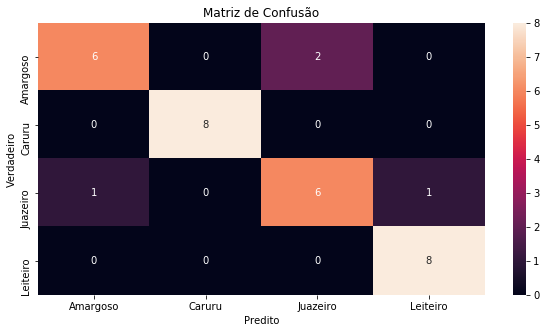

In [80]:
# Matriz de Confusao
matriz_confusao = confusion_matrix(y_id_tipo_praga_teste.values, result_svm_tipo_praga)

# Mapa com Seaborn
plt.figure(figsize=(10,5))
ax= plt.subplot()
sns.heatmap(matriz_confusao, annot=True, ax = ax);

ax.set_xlabel('Predito');
ax.set_ylabel('Verdadeiro'); 
ax.set_title('Matriz de Confusão'); 
ax.xaxis.set_ticklabels(['Amargoso', 'Caruru', 'Juazeiro', 'Leiteiro']); 
ax.yaxis.set_ticklabels(['Amargoso', 'Caruru', 'Juazeiro', 'Leiteiro']);
plt.savefig("matriz_confusao_tipo_praga.png", dpi=150) 


### Salvar o modelo via Pickle

In [81]:
# Nome do arquivo que será salvo o modelo
nome_arquivo_praga = 'modelos/svm_train_modelo_identificacao_tipo_praga.sav'

# Dump do modelo
pickle.dump(modelo_svm_tipo_praga, open(nome_arquivo_praga, 'wb'))

------------------------

## 7 - Aplicação da Solução para Identificação de Pragas em Colheitas nas bases de teste 

In [82]:
# Carregar os dados
# - SUBSTITUIR O ARQUIVO CSV DE TESTE PELO O QUE DESEJA SER AVALIADO
dados_praga_teste = pd.read_csv('data/conj_vdd_teste_identificacao_praga.csv')

# Embaralhar os dados
dados_praga_teste = dados_praga_teste.sample(n = 26) 

# Excluir e resetar as colunas que não são importantes
dados_praga_teste = dados_praga_teste.drop('Unnamed: 0', 1)
dados_praga_teste = dados_praga_teste.drop('index', 1)

#print(dados_praga_teste)

#------Features------
X_id_praga_teste = dados_praga_teste.iloc[:, 0: len(dados_praga_teste.columns)-1]
y_id_praga_teste = dados_praga_teste.iloc[:, len(dados_praga_teste.columns)-1:len(dados_praga_teste.columns)]

#------Normalização das Features------
scaler = Normalizer()
X_id_praga_teste = scaler.fit_transform(X_id_praga_teste)

#------Carregar o modelo de identificação de pragas------
model_identificacao_praga = joblib.load('modelos/rf_train_modelo_identificacao_praga.sav')

#------Carreegar o modelo de identificação de tipo de pragas------
model_identificacao_tipo_praga = joblib.load('modelos/svm_train_modelo_identificacao_tipo_praga.sav')

-----------------------------

### Dataframe com os resultados

In [83]:
#  Criação do Dataframe com resultados sintetizados
colunas = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'clear', 'saída', 'tipo']
df_resultado_predicao = pd.DataFrame(columns = colunas)

#------Experimentos com os dados da base de teste------
cont = 0
for index, row in dados_praga_teste.iterrows():
    print('Plantação: ', cont)
    print('Dados dos Sensores: f1 = {} | f2 = {} | f3 = {} | f4 = {} | f5 = {} | f6 = {} | f7 = {} | f8 = {} | clear = {}'.format(row.f1, row.f2, row.f3, row.f4, row.f5, row.f6, row.f7, row.f8, row.clear))
    
    # Inserindo informações no Dataframe dos resultados
    df_resultado_predicao.loc[cont, 'f1'] = row.f1
    df_resultado_predicao.loc[cont, 'f2'] = row.f2
    df_resultado_predicao.loc[cont, 'f3'] = row.f3
    df_resultado_predicao.loc[cont, 'f4'] = row.f4
    df_resultado_predicao.loc[cont, 'f5'] = row.f5
    df_resultado_predicao.loc[cont, 'f6'] = row.f6
    df_resultado_predicao.loc[cont, 'f7'] = row.f7
    df_resultado_predicao.loc[cont, 'f8'] = row.f8
    df_resultado_predicao.loc[cont, 'clear'] = row.clear
    
    # Prevendo se a plantação tem praga ou não
    resultado_id_praga = model_identificacao_praga.predict([X_id_praga_teste[cont]])
    
    df_resultado_predicao.loc[cont, 'saída'] = resultado_id_praga[0]
    
    # Caso a plantação tenha praga, logo identificar qual tipo de praga
    if resultado_id_praga[0] == 1.0:
        
        # Prevendo qual tipo de praga está presente na plantação
        resultado_id_tipo_praga = model_identificacao_tipo_praga.predict([X_id_praga_teste[cont]])
        
        # Praga do tipo Amargoso
        if resultado_id_tipo_praga[0] == 0.0:
            print('**Plantação com invasores do cultivo principal**')
            print('A plantação selecionada tem praga do tipo Amargoso!')
            
            df_resultado_predicao.loc[cont, 'tipo'] = "A"
            
        # Praga do tipo Caruru
        elif resultado_id_tipo_praga[0] == 1.0:
            print('**Plantação com invasores do cultivo principal**')
            print('A plantação selecionada tem praga do tipo Caruru!')
            
            df_resultado_predicao.loc[cont, 'tipo'] = "C"
            
        # Praga do tipo Juazeiro
        elif resultado_id_tipo_praga[0] == 2.0:
            print('**Plantação com invasores do cultivo principal**')
            print('A plantação selecionada tem praga do tipo Juazeiro!')
            
            df_resultado_predicao.loc[cont, 'tipo'] = "J"
            
        # Praga do tipo Leiteiro
        else:
            print('**Plantação com invasores do cultivo principal**')
            print('A plantação selecionada tem praga do tipo Leiteiro!')
            
            df_resultado_predicao.loc[cont, 'tipo'] = "L"
    else:
        print('**Plantação do cultivo principal**')
        print('A Plantação selecionada não tem praga!')
        
        df_resultado_predicao.loc[cont, 'tipo'] = "SEM PRAGA"
        
    print('\n')
    cont+=1

Plantação:  0
Dados dos Sensores: f1 = 239.0 | f2 = 290.0 | f3 = 389.0 | f4 = 490.0 | f5 = 610.0 | f6 = 685.0 | f7 = 779.0 | f8 = 918.0 | clear = 4067.0
**Plantação com invasores do cultivo principal**
A plantação selecionada tem praga do tipo Juazeiro!


Plantação:  1
Dados dos Sensores: f1 = 279.0 | f2 = 357.0 | f3 = 476.0 | f4 = 568.0 | f5 = 751.0 | f6 = 707.0 | f7 = 877.0 | f8 = 986.0 | clear = 5710.0
**Plantação do cultivo principal**
A Plantação selecionada não tem praga!


Plantação:  2
Dados dos Sensores: f1 = 269.0 | f2 = 382.0 | f3 = 483.0 | f4 = 664.0 | f5 = 774.0 | f6 = 850.0 | f7 = 1083.0 | f8 = 1308.0 | clear = 5917.0
**Plantação com invasores do cultivo principal**
A plantação selecionada tem praga do tipo Caruru!


Plantação:  3
Dados dos Sensores: f1 = 262.0 | f2 = 315.0 | f3 = 399.0 | f4 = 547.0 | f5 = 659.0 | f6 = 757.0 | f7 = 837.0 | f8 = 997.0 | clear = 4237.0
**Plantação do cultivo principal**
A Plantação selecionada não tem praga!


Plantação:  4
Dados dos Sensor

In [84]:
# Dataframe com os resultados sintetizados
print(df_resultado_predicao)

       f1     f2     f3      f4      f5      f6      f7      f8   clear saída  \
0   239.0  290.0  389.0   490.0   610.0   685.0   779.0   918.0  4067.0   1.0   
1   279.0  357.0  476.0   568.0   751.0   707.0   877.0   986.0  5710.0   0.0   
2   269.0  382.0  483.0   664.0   774.0   850.0  1083.0  1308.0  5917.0   1.0   
3   262.0  315.0  399.0   547.0   659.0   757.0   837.0   997.0  4237.0   0.0   
4   301.0  402.0  481.0   632.0   735.0   847.0   874.0  1096.0  6570.0   1.0   
5   240.0  311.0  405.0   528.0   630.0   702.0   842.0   990.0  3854.0   1.0   
6   322.0  447.0  570.0   727.0   919.0   997.0  1306.0  1521.0  7792.0   1.0   
7   252.0  316.0  398.0   534.0   665.0   705.0   779.0   930.0  4376.0   0.0   
8   361.0  489.0  581.0   727.0   965.0  1085.0  1060.0  1353.0  7678.0   1.0   
9   307.0  438.0  546.0   712.0   852.0   822.0  1032.0  1091.0  6841.0   0.0   
10  475.0  626.0  871.0  1023.0  1308.0  1397.0  1791.0  2207.0  8475.0   1.0   
11  301.0  369.0  442.0   58

-----------------

## 8 - Relatório de Desenvolvimento

### 1 - Seleção de Algoritmo/Técnica de IA

- Para o modelo de detecção de pragas o algoritmo escolhido foi o Random Forest (88.46% de acurácia), já para modelo de detecção de tipos de pragas o algoritmo escolhido foi o Support Vector Machine (88.69% de acurácia). Desse modo, a escolha foi baseada coforme o resultado obtido nos testes de avaliação em comparação com outros algoritmos e testes estatísticos.


### 2 - Critérios de Seleção de Dados Treinamento

- Balanceamento da Base de Dados de Treinamento para o modelo de detecção de pragas, sendo que a base tem 90% da quantidade de dados da menor proporção de dados dentre os rótulos dispostos.

- Base de Treinamento do modelo de identificação de pragas: 230 exemplos, sendo 115 do tipo 0 e sendo 115 do tipo 1.

- Base de Treinamento do modelo de identificação de tipo de pragas: 256 exemplos, sendo 64 do tipo A, sendo 64 do tipo C, sendo 64 do tipo J, sendo 64 do tipo L.



### 3 - Critérios de Seleção de Dados Validação

- Balanceamento da Base de Dados de Treinamento para o modelo de detecção de pragas, sendo que a base tem 10% da quantidade de dados da menor proporção de dados dentre os rótulos dispostos.

- Base de Treinamento do modelo de identificação de pragas: 26 exemplos, sendo 13 do tipo 0 e sendo 13 do tipo 1.

- Base de Treinamento do modelo de identificação de tipo de pragas: 32 exemplos, sendo 8 do tipo A, sendo 8 do tipo C, sendo 8 do tipo J, sendo 8 do tipo L.

### 4 - Critérios de Análise Prática dos Resultados

- Métricas de Avaliação:
    - Acurácia;
    - Precisão; 
    - Recall; 
    - F1-Score.
- Matriz de Confusão;
- Teste Estatístico:
    - Análise de Distribuição;
    - Análise de Variável Independente.

### 5 - Desenvolvimento

- Pré-processamento;
- Análise de Dados;
- Balanceamento e criação do conjunto de treinamento e teste para o modelo de identificação de pragas;
- Balanceamento e criação do conjunto de treinamento e teste para o modelo de identificação de tipos de pragas;
- Otimização de Hiperparâmetros;
- Criação do modelo de identificação de pragas;
- Validação do modelode de identificação de pragas;
- Testes Estatísticos para o modelo de identificação de pragas;
- Criação do modelo de identificação de tipos de pragas;
- Validação do modelode de identificação de tipo de pragas;
- Testes Estatísticos para o modelo de identificação de tipos de pragas;
- Aplicação dos modelos desenvolvidos em conjunto na base de teste.

### 6 - Problemas enfrentados

Quantidade de dados é pouca e meu computador não possui uma placa de vídeo, logo não consegui usufruir do processamento dos dados via GPU (CUDA).

### 7 - Técnicas utilizadas para enfrentar e resolver os problemas enfrentados

- Pré-processamento;
- Análise de Dados;
- Balanceamento da base de dados;
- Criação de conjunto verdade;
- Otimização de Hiperparâmetros;
- Desenvolvimento dos modelos de classificação;
- Validação dos modelos de classificação;
- Testes Estatísticos.